# Notebook for testing data for pilot 3

Pilot 3 added more checks for engagement early in the experiment.
Iteration names:
'pre-pilot3':

## 1. Read in packages and set up server connection
This first section will read in necessary packages for anaysis and establish file paths and connections to the mongo db server

In [48]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring

In [49]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [50]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['compositional-abstractions']
coll = db['two-towers']

# which iteration name should we use?
iterationName = 'pilot4'

## look up number of trials (including paired-practice)
numTrials = 13

## 2. Construct tidy dataframe with game data

### establish connection to mongo
First thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

`ssh -fNL 27017:127.0.0.1:27017 USERNAME@cogtoolslab.org`

#### Pass in list of iterations, returns list of total games and completed games for each

In [51]:
## get list of all gameIDs in database
#iterationList = ['livetest0','pilot0','pilot2']

iterationList = [iterationName]

for iteration in iterationList:
    #get total games
    total_games = coll.find({'iterationName':iteration}).distinct('gameid')
    print('There are {} total games in iteration: {}.'.format(len(total_games), iteration))

    ## get list of complete gameIDs
    gameIDs = coll.find({'iterationName':iteration}).distinct('gameid')
    complete_games = [g for g in gameIDs if len(coll.find({'gameid':g}).distinct('trialNum')) == numTrials]
    print('There are {} complete games in iteration: {}.'.format(len(complete_games), iteration))

There are 26 total games in iteration: pilot4.
There are 15 complete games in iteration: pilot4.


## Test functions for incoming data

In [32]:
#find bonus for a particular worker
pd.DataFrame(coll.find({'iterationName':iterationName, 'workerId': 'XXX'})).cumulativeBonus

0      NaN
1      NaN
2     0.00
3      NaN
4      NaN
      ... 
65     NaN
66     NaN
67     NaN
68    2.59
69     NaN
Name: cumulativeBonus, Length: 70, dtype: float64

In [37]:
# grab all data so far
a = pd.DataFrame(coll.find({'iterationName':iterationName}))

### get data for different kinds of failure
Only includes *submitted* data

In [45]:
# find all people who failed on quiz
quiz_fails = a[a.failType=='instructionsQuiz']
quiz_fails

,_id,workerId,failType,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,...,score,gameID,nativeEnglish,isHuman,confused,comments,strategy,role,totalLength,pairedPracticeFails
0,5f4fc5e01034572e6687f97c,A19ZWBQT8A3LIR,instructionsQuiz,pilot4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f4fc82d1034572e6687f97d,A2UV1ALOCZJGI7,instructionsQuiz,pilot4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f4fcb571034572e6687f97e,A3N4L5F7CEY0B2,instructionsQuiz,pilot4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,5f4fcd491034572e6687f992,A25JRQYK9DL0KE,instructionsQuiz,pilot4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,5f4fd34a1034572e6687f9a9,A1M1E62KXCDNL0,instructionsQuiz,pilot4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,5f516a901034572e6688033f,A3ASE3OEHY6KZO,instructionsQuiz,pilot4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2539,5f51784f1034572e66880367,A17K1CHOI773VZ,instructionsQuiz,pilot4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2540,5f5178c71034572e66880368,AVBGC3UVCWPDX,instructionsQuiz,pilot4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2541,5f517a431034572e66880369,AREQ43Q0T8ENT,instructionsQuiz,pilot4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# find all people who failed on solo practice
solo_fails = a[a.failType=='soloPractice']
solo_fails

,_id,workerId,failType,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,...,score,gameID,nativeEnglish,isHuman,confused,comments,strategy,role,totalLength,pairedPracticeFails
204,5f4fe6481034572e6687fa48,A1EP0JITQIOYIQ,soloPractice,pilot4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1329,5f5154821034572e6687fead,A3HYLVFUDKJFKC,soloPractice,pilot4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# find all people who failed on solo practice 
b = a[(a.eventType=='exitSurvey')]
paired_fails = b[b.pairedPracticeFails == 3]
paired_fails

,_id,workerId,failType,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,...,score,gameID,nativeEnglish,isHuman,confused,comments,strategy,role,totalLength,pairedPracticeFails
397,5f4fea141034572e6687fb09,A2WUXZOY4CRF5R,NaN,pilot4,1879-aef64278-6e02-4755-907a-075dd2383d24,1.599073e+12,3E47SOBEYUW78Q4UOK6BV9E7C80ICM,vertical,horizontal,NaN,...,NaN,A2WUXZOY4CRF5R,yes,human,yes,no,"As the words are limited, I tried to use simpl...",speaker,1028320.0,3.0
408,5f4fea3e1034572e6687fb14,A2837NCV9OXBFZ,NaN,pilot4,1879-aef64278-6e02-4755-907a-075dd2383d24,1.599073e+12,3LO69W1SU7DMF3S5B9Z7DGRER4MLGD,vertical,horizontal,NaN,...,NaN,A2837NCV9OXBFZ,yes,human,yes,Nothing,I do not use strategy,listener,636853.0,3.0
1323,5f5152b81034572e6687fea7,A2VO8C41JJIQY9,NaN,pilot4,9536-a5ff2384-044a-4905-bcf8-794c7cc3a926,1.599165e+12,3RGU30DZTE8GCN0RJRLPA6YJJCBJML,vertical,horizontal,NaN,...,NaN,A2VO8C41JJIQY9,no,human,yes,None~~~,I was trying to give as much as information po...,speaker,417145.0,3.0
1325,5f5153611034572e6687fea9,ARYL3C6N9SVV1,NaN,pilot4,9536-a5ff2384-044a-4905-bcf8-794c7cc3a926,1.599165e+12,36DSNE9QZ9Y4CQL3W7022ANOECQOJ5,vertical,horizontal,NaN,...,NaN,ARYL3C6N9SVV1,yes,human,yes,The only problem I had was having a partner th...,My partner provided very poor instructions~~~ ...,listener,541208.0,3.0
1395,5f5158391034572e6687feef,AKX9W0NF71OI7,NaN,pilot4,5312-bde29e51-6dd2-4407-999b-b1628c52f363,1.599167e+12,3ERET4BTVQ9WGNNFC3HW6ZSCY379KG,horizontal,vertical,NaN,...,NaN,AKX9W0NF71OI7,yes,program,yes,No,I tried to think about how I would need instru...,speaker,390555.0,3.0
1403,5f5158611034572e6687fef7,AIZUOHKQT14OM,NaN,pilot4,5312-bde29e51-6dd2-4407-999b-b1628c52f363,1.599167e+12,3E47SOBEYUW78Q4UOK6BV9E7CJICIK,horizontal,vertical,NaN,...,NaN,AIZUOHKQT14OM,yes,human,confused,No,I look the box and place the blocks~~~,listener,427938.0,3.0
1751,5f515de31034572e66880053,A2EOOF9D135HQ1,NaN,pilot4,1323-16b3e9d9-f8f6-4829-a2a9-a97ea5e3dfe0,1.599168e+12,3DIP6YHAPGSTGICVBP0F88KWUZQE87,horizontal,vertical,NaN,...,NaN,A2EOOF9D135HQ1,yes,human,yes,No,"Mine would have been to follow directions, but...",listener,899052.0,3.0
1782,5f515e2c1034572e66880072,A1P9HVNYM5POH,NaN,pilot4,1323-16b3e9d9-f8f6-4829-a2a9-a97ea5e3dfe0,1.599168e+12,3SLE99ER0RDATB1YAOY2KKBFQCSZB7,horizontal,vertical,NaN,...,NaN,A1P9HVNYM5POH,yes,human,yes,nothing,i done my task by intuitive,speaker,986330.0,3.0
2555,5f517c571034572e66880377,A32LHQYJY0ELFS,NaN,pilot4,5133-a539d2c0-e73e-4ed4-8c64-a2141d8a8528,1.599176e+12,388U7OUMFB107XCX2R70E0DXQRYR06,horizontal,vertical,NaN,...,NaN,A32LHQYJY0ELFS,yes,human,yes,no,it's encouraging,listener,428581.0,3.0


In [57]:
# How many trials did each dyad complete?
c = a[(a.turnNum==0) & (a.eventType=='chatMessage') & (a.trialNum!='practice')]
num_trials_complete = c.groupby(['gameid']).count()

In [58]:
broken_games = []
complete_games = [g for g in complete_games if g not in broken_games]

def construct_tidy_dataframe(eventType = 'chatMessage', 
                             complete_games = [],
                             iterationName = 'pilot4',
                             remove_workerID = True):
    '''
    input: list of complete games and name of event Type
    '''
    event2name = {'chatMessage':'chat', 'block':'block', 'endTrial':'trial', 'exitSurvey':'exit'}
    L = pd.DataFrame()
    for g, this_gameID in enumerate(complete_games):
        print('Analyzing game {} | {} of {}'.format(this_gameID, g+1, len(complete_games)))
        clear_output(wait=True) 

        ### extract records 
        #loop over iteration names??
        X = coll.find({ '$and': [{'iterationName':iterationName}, 
#                                  {"$or":[{'iterationName':'Exp2Pilot3'},
#                                  {'iterationName':'Exp2Pilot3_batch2'}]}
                                 {'gameid': this_gameID}, {'eventType': eventType}]}).sort('time') 
        
        li = list(X)        
        _L = pd.DataFrame(li)  

        ## concat with previous game's dataframe
        if L.shape[0]==0:
            L = _L
        else: 
            L = pd.concat([L,_L], axis=0)     

    ## postprocessing
    if remove_workerID and 'workerId' in L.columns:
        L = L.drop('workerId',axis=1)
        
    if eventType in ['block','endTrial','chatMessage']:
        L['practice'] = L.trialNum == 'practice'
        L.trialNum = pd.to_numeric(L['trialNum'], errors='coerce')

    ## save out group dataframe to csv dir
    out_path = os.path.join(csv_dir,'compabs_{}_{}.csv'.format(event2name[eventType],iterationName))
    print('Saving dataframe out to CSV dir at path: {}'.format(out_path))    
    L.to_csv(out_path)             

    return L


In [59]:
## construct dataframe for each datatype
dataTypes = coll.distinct('eventType')
for thisDataType in dataTypes:
    X = construct_tidy_dataframe(eventType=thisDataType, complete_games=complete_games, iterationName=iterationName)


Saving dataframe out to CSV dir at path: /Users/will/compositional-abstractions/results/csv/compabs_exit_pilot4.csv


## 3. Create a full DF from DB
We can read in a full df from the db and do some basic checks to make sure the data look right

#### check outcome for specific workerID
Must pass in gameid and corresponding iteration

In [60]:
f = pd.DataFrame(coll.find({'iterationName': 'pilot4'}))
f['gameid'].unique()

array([nan, '0908-f3ab6027-9304-44e0-a5c1-535e7c3818ca',
       '0741-0d5c3f38-e1fa-4a05-9f35-4a81c7cdbd71',
       '8263-001a1b6c-ab69-48aa-8807-752d70fb55cf',
       '7479-30d049e8-f8fb-4831-b814-9f87cdaa4e88',
       '6064-78a665ff-7528-45c6-91d1-960cc9647fa6',
       '1879-aef64278-6e02-4755-907a-075dd2383d24',
       '0208-b497c845-b076-45c9-b958-a62a3ae6e65f',
       '4244-cb63e4ee-2692-4273-8dcb-45c1cde2496a',
       '2299-81bf7587-5407-4d48-852c-8a98d73da3a6',
       '9961-1bd92164-cbe7-4841-8225-7de8486bf84a',
       '1784-6a1a6495-d93c-4385-a09d-2c9d9fe876e1',
       '9536-a5ff2384-044a-4905-bcf8-794c7cc3a926',
       '4549-7984d0d9-9b1b-4cd2-bc24-418399e72408',
       '1492-f78451b1-e842-4a69-ba16-23efd8c22f88',
       '4548-d4f8915b-8223-4cc4-b5b4-889e40eb849f',
       '5312-bde29e51-6dd2-4407-999b-b1628c52f363',
       '6169-888a2828-0e46-483c-b48d-cf18271187ed',
       '4978-4c585194-1823-46fc-989c-e6200c5d61e6',
       '1323-16b3e9d9-f8f6-4829-a2a9-a97ea5e3dfe0',
       

In [7]:
#set worker ID
workerID = 'testsubject003'

#get GameID (not all info available at workerID level (e.g. bonus))
gameID = df_full[df_full['workerId'] == workerID]['gameid'].unique()[0]

#check iteration name
df_game = df_full[(df_full['iterationName'] == iterationName) &
                            (df_full['gameid'] == gameID)]
#get workerIds
print('workerIDS:',df_game['workerId'].unique())
#get bonus for gameID ([air of workerIDs])
print("Bonus:",np.nanmax(df_game['cumulativeBonus']))

NameError: name 'df_full' is not defined

In [ ]:
#see full history for single worker
df_test = df_full[(df_full['iterationName'] == iterationName)&
                           (df_full['workerId'] == workerID)]
df_test.content.unique()

## 4. Trial Level Data
We're going to construct a spearate df for each event type (chat, block, endTrial, Survey) which will make analysis a little easier.
We also want to be able to concatenate multiple iterations for grouped analysis of previous versions.

### Load data from CSVs

In [66]:
# Load csvs for this iterationName

event_types = ['block', 'chat','exit','trial']
iteration_list = [iterationName]
df_dict = {}
for event in event_types:
    event_dict = {}
    df_name = 'df_'+ event
    for iteration in iteration_list:
        df_temp = 'df_'+event+"_"+iteration # the name for the dataframe
        file_name = '../results/csv/compabs_{}_{}.csv'.format(event,iteration)
        event_dict[df_temp] = pd.read_csv(file_name)
    df_dict[df_name] = pd.concat(event_dict.values(), ignore_index = True)

In [67]:
# Save loaded CSVs locally 

df_dict['df_block'].to_csv('df_block.csv', header=True, index=False) 
df_dict['df_chat'].to_csv('df_chat.csv', header=True, index=False) 
df_dict['df_exit'].to_csv('df_exit.csv', header=True, index=False) 
df_dict['df_trial'].to_csv('df_trial.csv', header=True, index=False) 

#### Read in CSVs

In [68]:
#read in dataframes from each eventType
df_block = pd.read_csv('df_block.csv')
df_chat = pd.read_csv('df_chat.csv')
df_exit = pd.read_csv('df_exit.csv')
df_trial = pd.read_csv('df_trial.csv')

## 5. General Analysis
Now that we have our dfs constructed, we can do some basic analysis. If you prefer to analyze in R, there is a separate notebook in this directory that reads in the .csv files previously constructed. But if you're feeling particularly pythonic, carry on.

#### Exclusion Criteria

In [128]:
# How many dyads fulfill 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

#delete rows that aren't greater than 75% in 9 trials
df75 = df75[df75['trials']>=9]

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 11


In [129]:
includedGames = list(df75.reset_index().gameid)

In [133]:
# Exclude from analysis
df_block = df_block[df_block.gameid.isin(includedGames)]
df_chat = df_chat[df_chat.gameid.isin(includedGames)]
df_exit = df_exit[df_exit.gameid.isin(includedGames)]
df_trial = df_trial[df_trial.gameid.isin(includedGames)]

In [70]:
#df_exit2 = pd.read_csv('../results/csv/compabs_exit_pilot2.csv')
df_exit.confused.unique()

array(['yes'], dtype=object)

In [71]:
df_exit.nativeEnglish.unique()

array(['yes', 'no'], dtype=object)

#### Total Game Duration (for Gameplay)

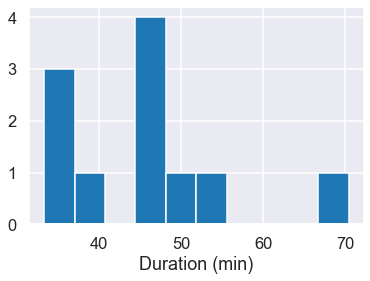

In [135]:
(df_exit.groupby(['gameid'])['totalLength'].max()/60000).hist()
plt.xlabel("Duration (min)")
plt.show()

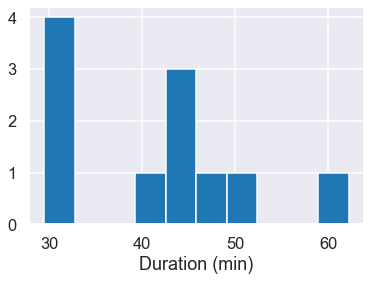

In [136]:
(df_exit.groupby(['gameid'])['totalLength'].min()/60000).hist()
plt.xlabel("Duration (min)")
plt.show()

In [137]:
#average completion time
(df_exit.groupby(['gameid'])['totalLength'].max()/60000).mean()

45.48952575757576

### 5. 1 Inspect one dyad: language

In [74]:
# grab one game id
gameids = list(df_chat.gameid.unique())
dyadGameId = gameids[1]

In [75]:
#create columns for char and word counts
df_chat['word_count'] = df_chat['content'].str.split(' ').str.len()
df_chat['char_count'] = df_chat['content'].str.len()

In [76]:
#inspect specific chat history of one dyad
df_chat[(df_chat.gameid == dyadGameId)]['content'].unique()

array(['Place a blue domino 2 spaces from the left and a red 3 spaces from the right~~~',
       'place 2 blue right next to each other starting from 1 space from the left~~~',
       'Place 2 red, on top of the furthest left blue squre (1 space from the left)~~~',
       'Place a red 1 space from the right, leave 2 spaces and place 1 more red ',
       'Place 2 blues, on top of the reds you just placed~~~ Like a table~~~ ',
       'same shape as the last trial~~~ 1 red placed 1 space from right, leave 2 space for 1 red, blue table',
       'place 1 blue 2 spaces from left~~~ Top the furthest left square with 2 reds~~~',
       'Sorry~~~ Place 2 reds on top of the blue that you just placed, on the left square~~~',
       'Place 2 blue next to each other, 1 space from the right~~~ ',
       'Place 2 blue next to each other, 1 space from the left~~~ ',
       'Place 2 red on top of each other on top of the furthest blue square~~~',
       'Place 2 red on top of each other on top of the f

In [224]:
df_chat[(df_chat.gameid == gameids[0])]['content'].unique()

array(['There is a horizontal block in the middle of the red line on the left~~~',
       'there is a vertical block directly left of the red line on the right',
       'horizontal block middle of red line left side\n',
       'vertical block on top of this one on the left side',
       'one more the same on top of it',
       'now a horizontal one above that, it should go to the right',
       'right red line, go left 2 blocks and there is a vertical block',
       'sorry, too far, go above that one, and one block right and do a horizontal line that goes to the t',
       'now one more horizontal to the right of that',
       'go two spaces to the right from the red line and put one vertical',
       'left red line 2 horizontal blocks one on each side of the line',
       'yes, now put one to the right of that, horizontal',
       'on the left side of your first block put a vertical block above it\n',
       'yes, now one more above it',
       'now the right red line~~~  skip one blo

### 5. 2 Inspect one dyad: display block towers

In [58]:
importlib.reload(drawing)
df_block['w'] = df_block['width']
df_block['h'] = df_block['height']
floatCols = ['w','h','blockNum','turnNum','x','y']
df_block[floatCols] = df_block[floatCols].applymap(np.int64)

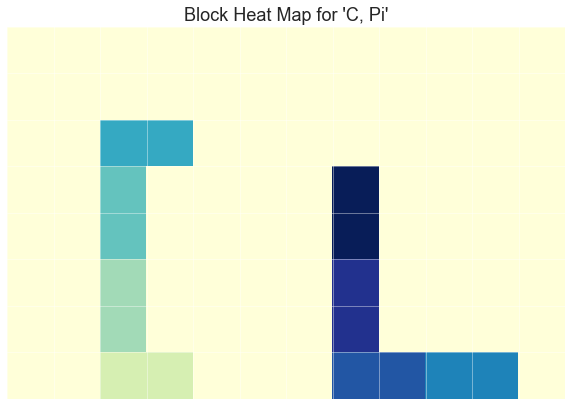

In [90]:
trial_data = df_block[(df_block.gameid == dyadGameId) &\
                      (df_block.trialNum == 3)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
drawing.draw_from_actions_subplot(trial_data, 
                                  ax, 
                                  world_size = [12,8])
plt.title("Block Heat Map for 'C, Pi'")
plt.show()

## 5.3 Make basic visualizations and calculate descriptives

### Messages

In [78]:
trial_sums = df_chat.groupby(['gameid','trialNum']).sum().reset_index()
rep_sums = df_chat.groupby(['gameid','repNum']).sum().reset_index()

trial_counts = df_chat.groupby(['gameid','trialNum']).count().reset_index()

#### Trial to trial

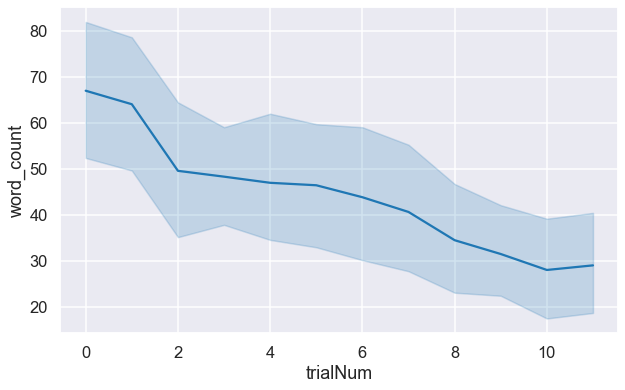

In [138]:
# word count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=trial_sums[~trial_sums.practice], x='trialNum', y='word_count')
             #, hue='gameid')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

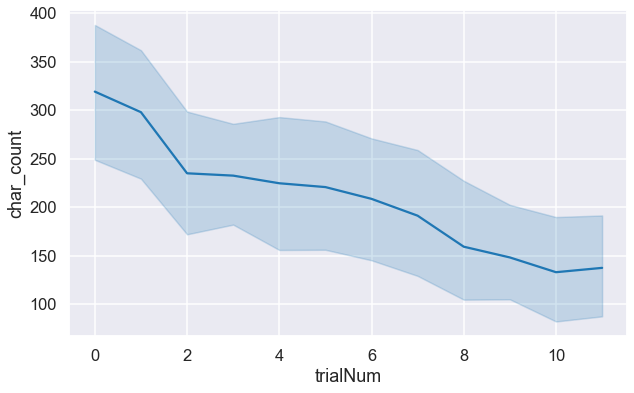

In [139]:
# char count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=trial_sums, x='trialNum', y='char_count')
             #, hue='gameid')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

#### Repetition to repetition (of tower pairs?)

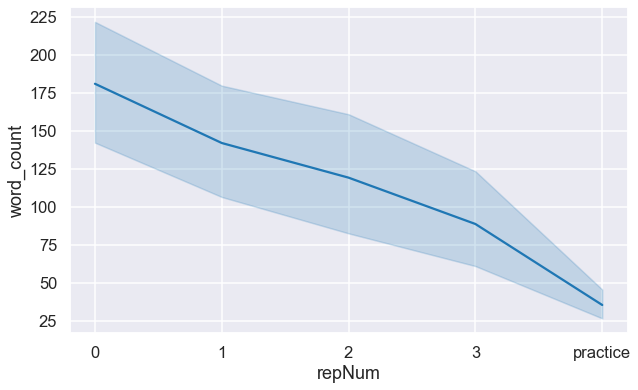

In [140]:
# word count across reps

plt.figure(figsize=(10,6))
sns.lineplot(data=rep_sums, x='repNum',y='word_count')

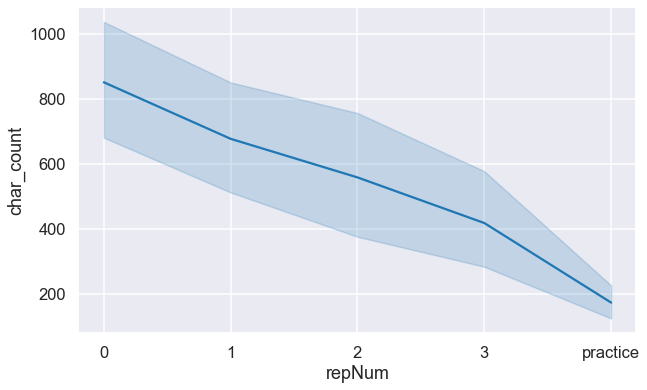

In [141]:
# Char count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=rep_sums, x='repNum',y='char_count')

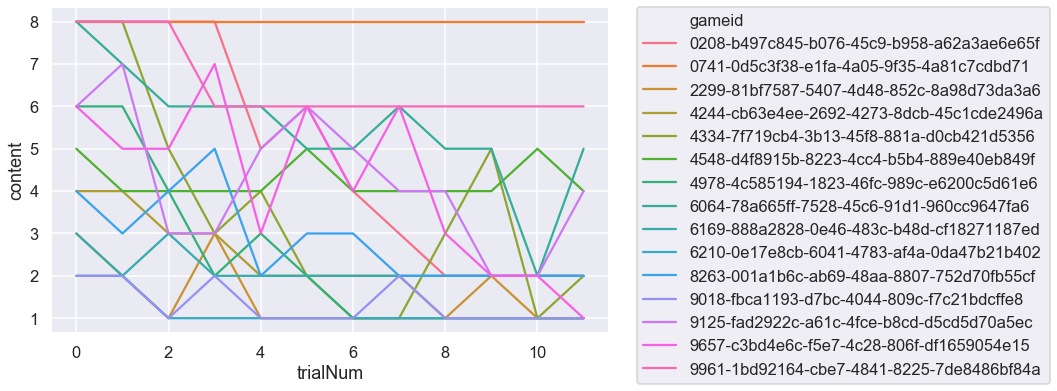

In [142]:
# Number of messages across trials (by game)

plt.figure(figsize=(10,6))
sns.lineplot(data=trial_counts, x='trialNum',y='content', hue='gameid') 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
# y variable doesn't matter here- it just counts the number of rows in each group

In [231]:
messages = df_chat.groupby(['gameid','trialNum'])['content'].agg(lambda x: "\\\"".join(x)).reset_index()
with pd.option_context('display.max_colwidth', -1):  # more options can be specified also
    print(messages[['trialNum','content']])

    trialNum  \
0   0.0        
1   1.0        
2   2.0        
3   3.0        
4   4.0        
..  ...        
67  7.0        
68  8.0        
69  9.0        
70  10.0       
71  11.0       

                                                                                                                                                                                                           content  
0   blue 2,1\"blue 4,1\n\"blue 9,1\n\"red 2,2\"red 2, 4\"red 9,2\"red 9,4\"blue 9,6\n                                                                                                                               
1   blue 2,1\"blue 4,1\"red 2,2\n\"red 2,4\"red 8,1\"red 11, 1\"blue 8, 3\"blue 10, 3                                                                                                                               
2   blue 3,1\"red 3,2\"another red on top of that one\"blue 3, 6\"red 8,1\n\"red 11, 1\"just like the last time with the blue blocks on top 8,3 \"perfect               

### Accuracy

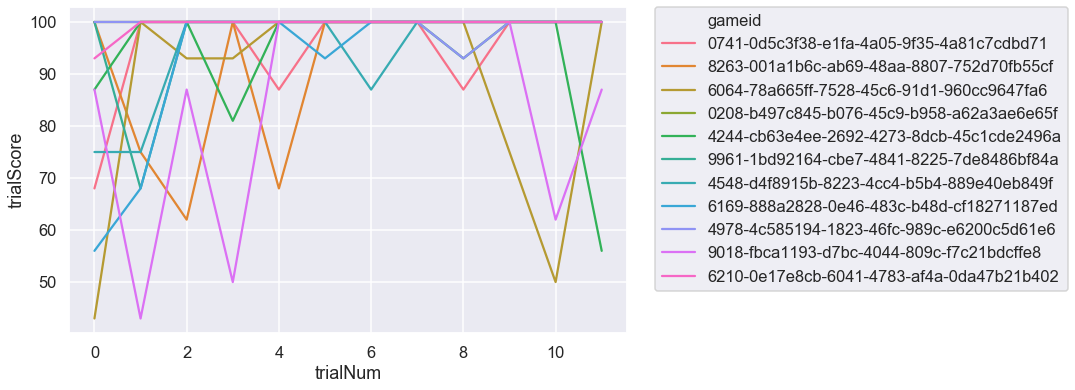

In [143]:
# accuracy across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='trialScore', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

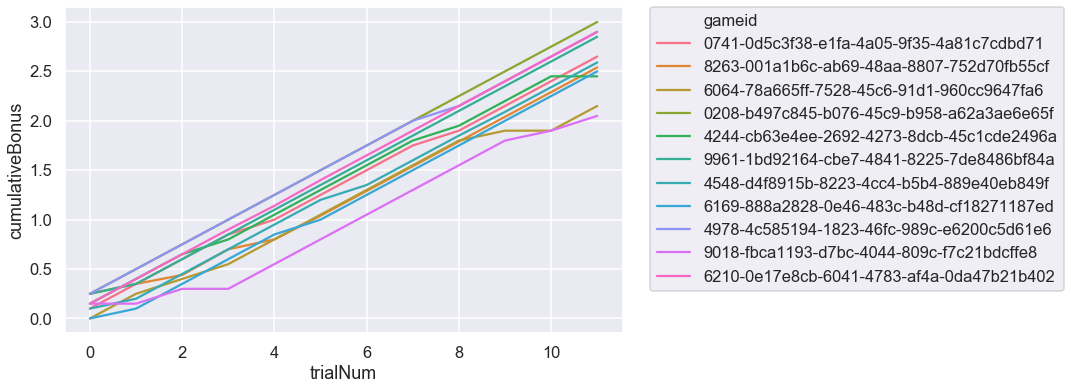

In [146]:
# bonus across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='cumulativeBonus', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

### Timing variables 

#### Create timings dataframe

In [147]:
df_trial_time = df_block[~df_block.practice].groupby(['gameid','trialNum'])\
                ['timeElapsedInTrial'].max().reset_index()

df_trial_time = df_trial_time.rename(columns = {'timeElapsedInTrial':'time_final_block'})

In [148]:
chat_times = df_chat[~df_chat.practice].groupby(['gameid','trialNum'])\
['timeElapsedInTurn'].sum().reset_index()


In [149]:
total_block_times = df_block[(~df_block.practice)].groupby(['gameid','trialNum','turnNum'])\
                    ['timeElapsedInTurn'].max()\
                    .groupby(['gameid','trialNum']).sum().reset_index()

In [150]:
# time from trial_start to final block placed in turn, summed across the trial
df_trial_time['total_block_duration'] = total_block_times['timeElapsedInTurn'] 

# time from trial_start to chat message sent, summed across the trial
df_trial_time['total_chat_duration'] = chat_times['timeElapsedInTurn']

# sum of block placement and chat time in a trial
df_trial_time['total_duration'] = df_trial_time['total_chat_duration'] + df_trial_time['total_block_duration']

# differnce between final block placement time and total chat plus block placement time.
# i.e. the total extra time in a trial, mainly consisting of time to press done button
df_trial_time['diff'] = df_trial_time['time_final_block'] - df_trial_time['total_duration']

# in addition, add a total_turn_duration- 
#  the time between this turn start and the next turn start (or final block placement)
#  as an estimate for when the Done button is pressed.
# didn't have the data for this in pilot3- we are now saving turnStartTime

df_trial_time

,gameid,trialNum,time_final_block,total_block_duration,total_chat_duration,total_duration,diff
0,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,0.0,160473,60667,92052,152719,7754
1,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,1.0,142643,57888,77979,135867,6776
2,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,2.0,169801,53454,106665,160119,9682
3,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,3.0,120443,27870,85860,113730,6713
4,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,4.0,126905,49004,72603,121607,5298
...,...,...,...,...,...,...,...
127,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,7.0,134181,38337,89008,127345,6836
128,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,8.0,127978,41130,80889,122019,5959
129,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,9.0,124625,37141,81506,118647,5978
130,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,10.0,123427,50428,66823,117251,6176


#### Plots

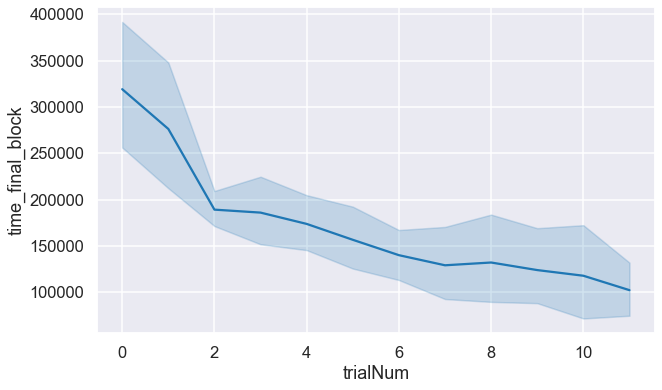

In [162]:
# total trial time until final block placement

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time, x='trialNum', y='time_final_block')

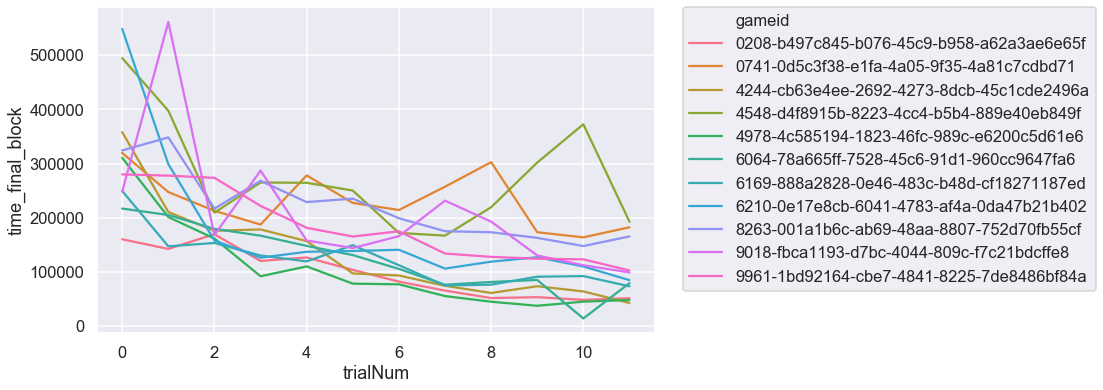

In [152]:
# total trial time until final block placement

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time, x='trialNum', y='time_final_block', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

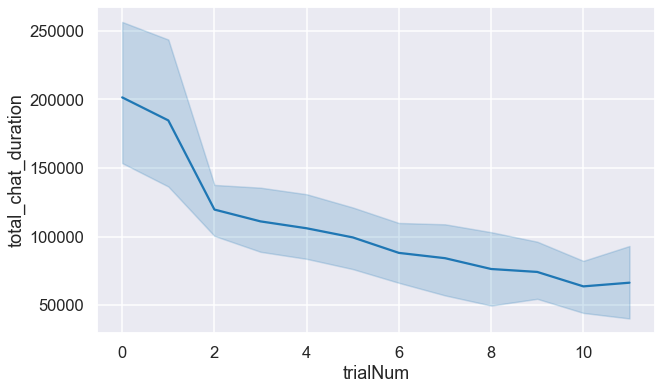

In [161]:
# total time from start of turn to message sent in all turns

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time, x='trialNum', y='total_chat_duration')

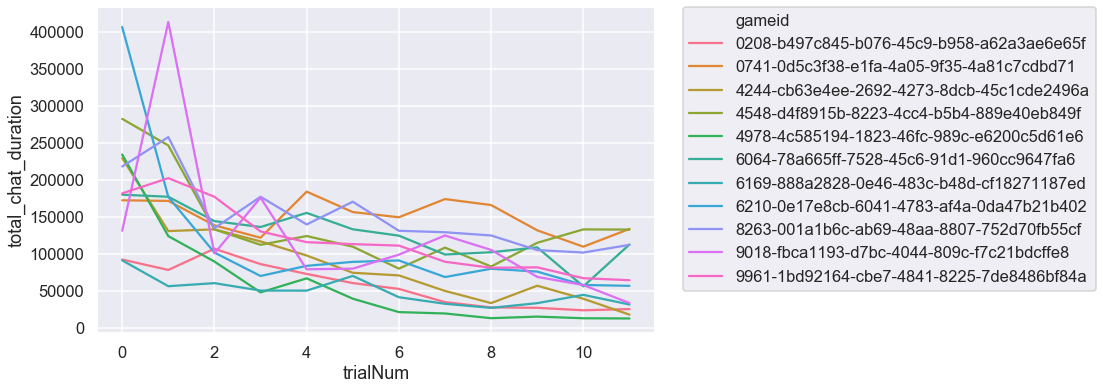

In [153]:
# total time from start of turn to message sent in all turns

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time, x='trialNum', y='total_chat_duration', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

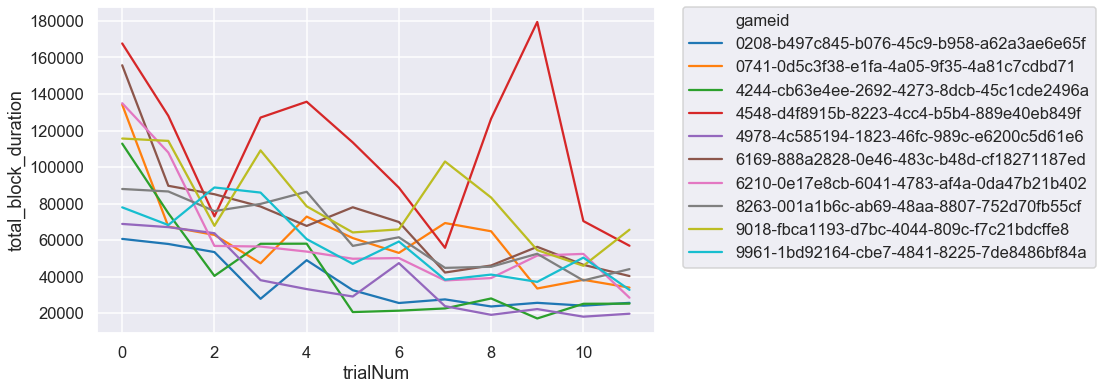

In [157]:
# total time from start of turn to final block placement in all turns

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time[df_trial_time.gameid != '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='total_block_duration', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

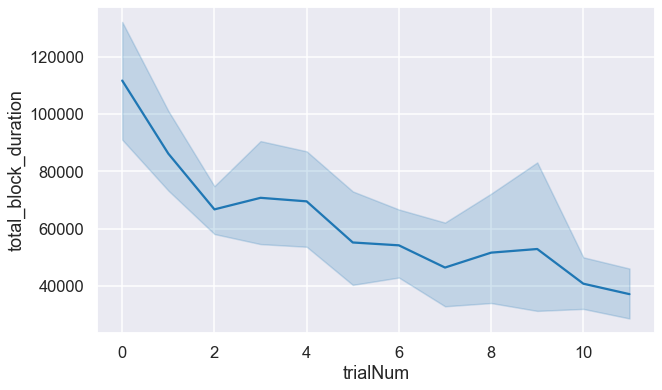

In [163]:
# total time from start of turn to final block placement in all turns

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time[df_trial_time.gameid != '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='total_block_duration')

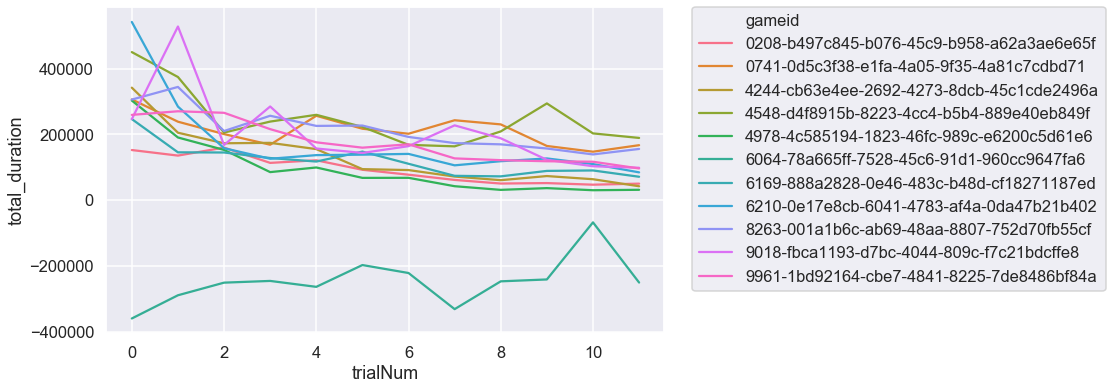

In [155]:
# max time in trial

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time, x='trialNum', y='total_duration', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

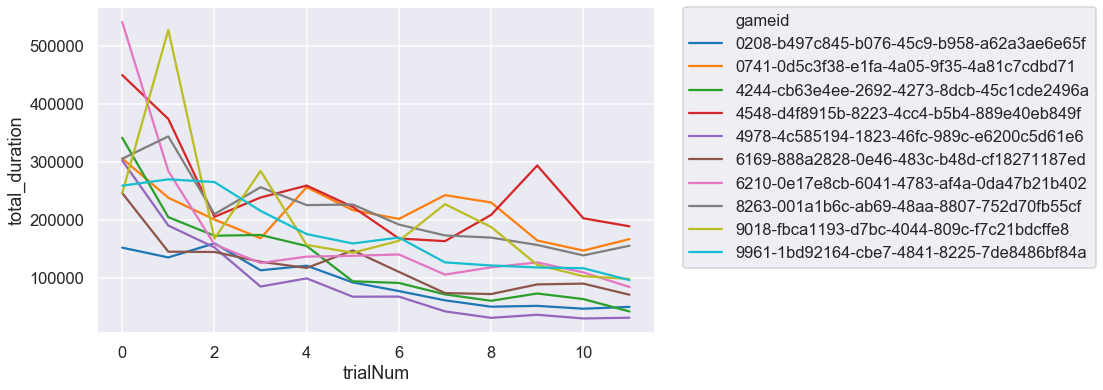

In [158]:
# max time in trial

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial_time[df_trial_time.gameid != '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='total_duration', hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

#### Builder: Reconstruction accuracy (intersection over union, IOU) across trials

Text(0, 0.5, 'Trial Score')

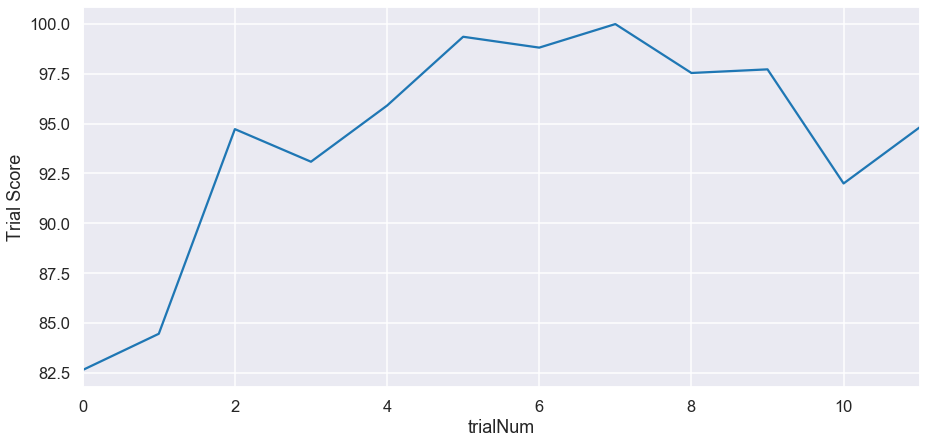

In [156]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['trialNum','gameid'])['trialScore'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Trial Score')

Text(0, 0.5, 'Trial Score')

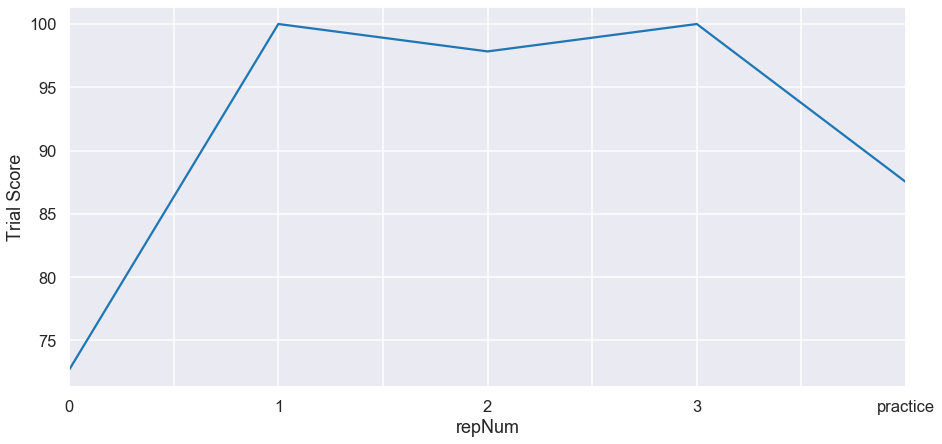

In [179]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['gameid','repNum'])['trialScore'].mean().groupby(['repNum']).mean().plot(ax = ax)
plt.ylabel('Trial Score')

Text(0, 0.5, 'Trial Score')

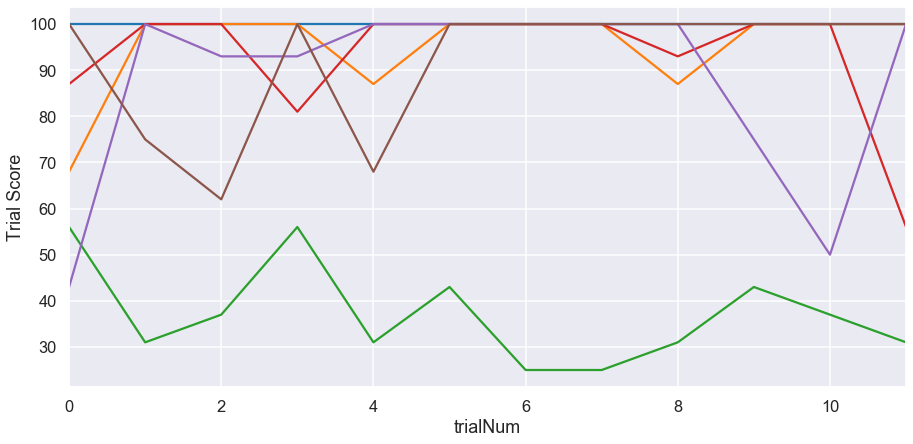

In [248]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['trialNum','gameid'])['trialScore'].sum().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Trial Score')

Text(0, 0.5, 'Trial Score')

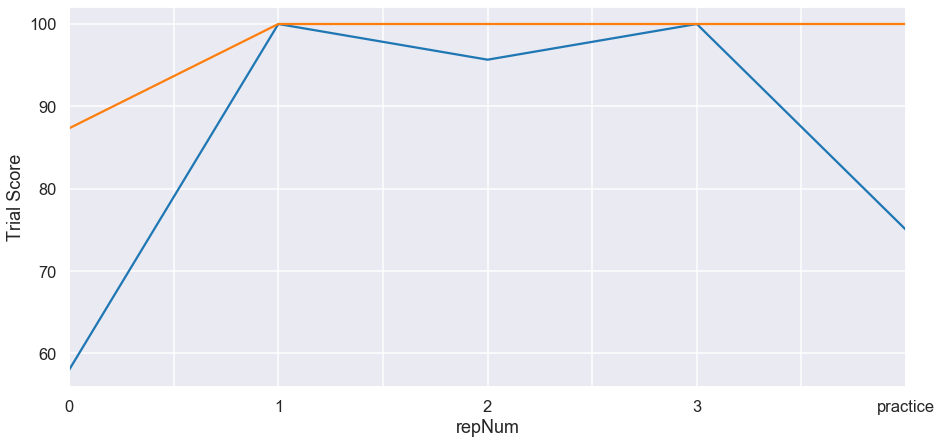

In [181]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['repNum','gameid'])['trialScore'].mean().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Trial Score')

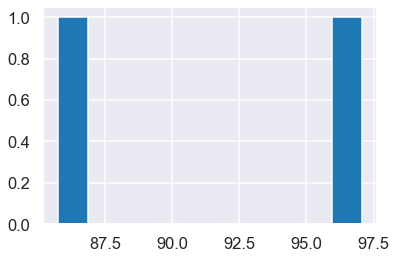

In [182]:
df_trial.groupby(['gameid'])['trialScore'].mean().hist()

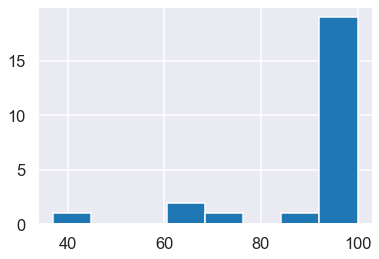

In [183]:
#Dist of trial scores:
(df_trial.groupby(['gameid','trialNum']).trialScore.max().hist(bins = 8))
plt.show()


#### Builder: Distribution of blocks placed per utterance


In [ ]:
(df_block.groupby(['gameid','trialNum', 'turnNum'])['_id'].count()).hist(bins = 8)
plt.show()


#### Builder: Total reconstruction time (summed build time across turns, within each trial) across trials

In [ ]:
#check time elapsed
df_block["timeElapsedInTurn"] = pd.to_numeric(df_block['timeElapsedInTurn'])

In [ ]:
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum()

In [ ]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Builder')

In [ ]:
## line plots: time for each builder
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['trialNum','gameid'])['timeElapsedInTurn'].sum().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Time elapsed in trial Builder')

In [ ]:
df_block.timeElapsedInTurn.min()

In [104]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_trial['trialNum'] = pd.to_numeric(df_trial['trialNum'], errors = 'coerce')
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_block['trialNum'] = pd.to_numeric(df_block['trialNum'], errors = 'coerce')

#### Architect: Total typing time (across turns within at trial) across trials

In [39]:
#check time elapsed
df_chat["timeElapsedInTurn"] = pd.to_numeric(df_chat['timeElapsedInTurn'])

Text(0, 0.5, 'Average Time elapsed, Architect')

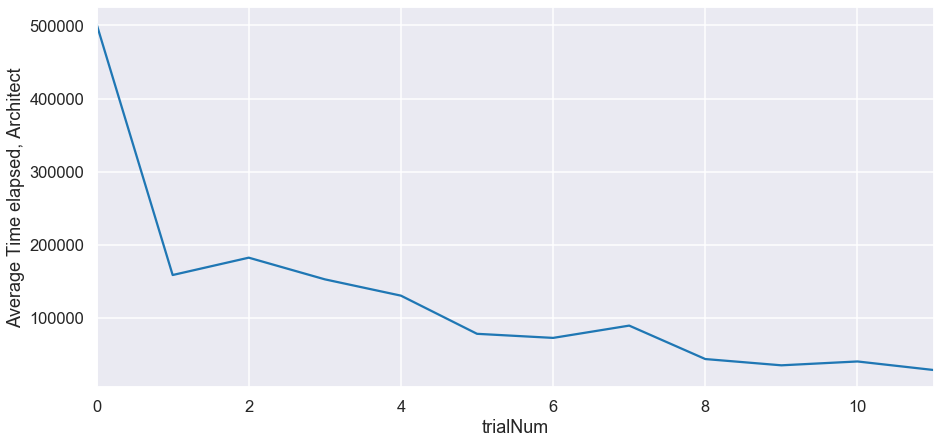

In [40]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Architect')

In [41]:
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean()

trialNum
0.0     501734.5
1.0     158750.5
2.0     182462.5
3.0     152852.0
4.0     130560.0
5.0      78405.0
6.0      72821.0
7.0      89611.5
8.0      43912.5
9.0      35352.5
10.0     40612.5
11.0     28941.5
Name: timeElapsedInTurn, dtype: float64

## Import R plots from RSS 2020

In [9]:
!conda install rpy2
import rpy2

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                                         \failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - anaconda-project -> python[version='>=3.8,<3.9.0a0']
  - anaconda==2020.02 -> python[version='3.6.10|3.7.6|3.8.1',build='h359304d_1|h359304d_2|h359304d_0']
  - autopep8 -> python[version='>=3.8,<3.9.0a0']
  - backports.functools_lru_cache -> python[version='>=2.7,<2.8.0a0']
  - bleach -> python[version='>=3.8,<3.9.0a0']
  - boto3 -

imageio -> python[version='>=3'] -> sqlite[version='>=3.20.1,<4.0a0|>=3.22.0,<4.0a0|>=3.23.1,<4.0a0|>=3.24.0,<4.0a0|>=3.25.2,<4.0a0|>=3.25.3,<4.0a0|>=3.26.0,<4.0a0|>=3.27.2,<4.0a0|>=3.29.0,<4.0a0|>=3.30.0,<4.0a0|>=3.30.1,<4.0a0|>=3.31.1,<4.0a0|>=3.32.3,<4.0a0|>=3.33.0,<4.0a0']
backcall -> python -> sqlite[version='>=3.20.1,<4.0a0|>=3.22.0,<4.0a0|>=3.23.1,<4.0a0|>=3.24.0,<4.0a0|>=3.25.2,<4.0a0|>=3.25.3,<4.0a0|>=3.26.0,<4.0a0|>=3.27.2,<4.0a0|>=3.29.0,<4.0a0|>=3.30.0,<4.0a0|>=3.30.1,<4.0a0|>=3.31.1,<4.0a0|>=3.32.3,<4.0a0|>=3.33.0,<4.0a0']
pytest-astropy -> python -> sqlite[version='>=3.20.1,<4.0a0|>=3.22.0,<4.0a0|>=3.23.1,<4.0a0|>=3.24.0,<4.0a0|>=3.25.2,<4.0a0|>=3.25.3,<4.0a0|>=3.26.0,<4.0a0|>=3.27.2,<4.0a0|>=3.29.0,<4.0a0|>=3.30.0,<4.0a0|>=3.30.1,<4.0a0|>=3.31.1,<4.0a0|>=3.32.3,<4.0a0|>=3.33.0,<4.0a0']
anaconda==2020.02 -> sqlite==3.31.1=ha441bb4_0
patsy -> python[version='>=3.8,<3.9.0a0'] -> sqlite[version='>=3.20.1,<4.0a0|>=3.22.0,<4.0a0|>=3.23.1,<4.0a0|>=3.24.0,<4.0a0|>=3.25.2,<4.0a0|

ModuleNotFoundError: No module named 'rpy2'

In [6]:
import rpy2.rinterface
%load_ext rpy2.ipython


%%R -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
ggplot(block_dyad,  aes(x = repNum, y = blocksPlaced))+
  geom_line(aes(group = gameid), alpha = 0.3)+
  geom_line(data =block_grouped, aes(x = repNum, y = blocksPlaced), size = 2, color = 'red')+
  #theme_bw()+
  xlab('Repetition Number')+
  ylab('Number of Blocks per Instruction')

## Explore negative timing data

In [251]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6']

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,...,color,block,blockNum,discreteWorld,trialStartTime,turnStartTime,timeElapsedInTurn,timeElapsedInTrial,eventType,practice
196,0,5f4fe3e01034572e6687f9d3,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599071e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,vertical,horizontal,NaN,1,...,"[179, 47, 10, 155]","{'x': 2, 'y': 0, 'width': 1, 'height': 2, 'col...",0,"[[False, False, False, False, False, False, Fa...",1.599071e+12,1.599071e+12,-60051,-17971,block,True
197,1,5f4fe4061034572e6687f9dc,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599071e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,vertical,horizontal,NaN,3,...,"[10, 47, 179, 155]","{'x': 8, 'y': 0, 'width': 2, 'height': 1, 'col...",1,"[[False, False, False, False, False, False, Fa...",1.599071e+12,1.599071e+12,-71099,19168,block,True
198,2,5f4fe4221034572e6687f9e5,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599071e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,L,C,0.0,1,...,"[10, 47, 179, 155]","{'x': 8, 'y': 0, 'width': 2, 'height': 1, 'col...",0,"[[False, False, False, False, False, False, Fa...",1.599071e+12,1.599071e+12,-70126,-56255,block,False
199,3,5f4fe45c1034572e6687f9f0,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599071e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,L,C,0.0,3,...,"[179, 47, 10, 155]","{'x': 0, 'y': 0, 'width': 1, 'height': 2, 'col...",1,"[[True, True, False, False, False, False, Fals...",1.599071e+12,1.599071e+12,-47719,1074,block,False
200,4,5f4fe4831034572e6687f9f5,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599071e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,L,C,0.0,5,...,"[179, 47, 10, 155]","{'x': 9, 'y': 1, 'width': 1, 'height': 2, 'col...",2,"[[True, True, False, False, False, False, Fals...",1.599071e+12,1.599071e+12,-68539,40167,block,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,93,5f4fed981034572e6687fc17,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599074e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,C,L,11.0,5,...,"[10, 47, 179, 155]","{'x': 2, 'y': 5, 'width': 2, 'height': 1, 'col...",3,"[[False, False, False, False, False, False, Fa...",1.599074e+12,1.599074e+12,-76077,12663,block,False
290,94,5f4fedc01034572e6687fc29,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599074e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,C,L,11.0,7,...,"[10, 47, 179, 155]","{'x': 9, 'y': 0, 'width': 2, 'height': 1, 'col...",4,"[[False, False, False, False, False, False, Fa...",1.599074e+12,1.599074e+12,-71210,52678,block,False
291,95,5f4fedc21034572e6687fc2a,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599074e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,C,L,11.0,7,...,"[10, 47, 179, 155]","{'x': 7, 'y': 0, 'width': 2, 'height': 1, 'col...",5,"[[False, False, False, False, False, False, Fa...",1.599074e+12,1.599074e+12,-68576,55312,block,False
292,96,5f4fedd91034572e6687fc34,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599074e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,C,L,11.0,9,...,"[179, 47, 10, 155]","{'x': 7, 'y': 1, 'width': 1, 'height': 2, 'col...",6,"[[False, False, False, False, False, False, Fa...",1.599074e+12,1.599074e+12,-76345,77826,block,False


In [301]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].time\
    - df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].turnStartTime 

196   -60051.0
197   -71099.0
198   -70126.0
199   -47719.0
200   -68539.0
        ...   
289   -76076.0
290   -71210.0
291   -68576.0
292   -76345.0
293   -74680.0
Length: 98, dtype: float64

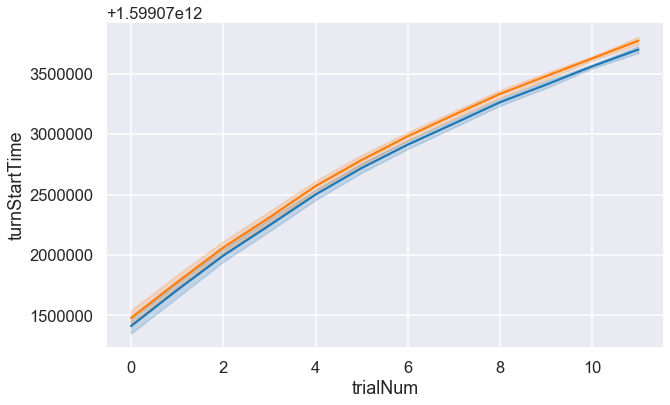

In [311]:

plt.figure(figsize=(10,6))
sns.lineplot(data=df_block[df_block.gameid =='6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='time')
sns.lineplot(data=df_block[df_block.gameid =='6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='turnStartTime')
#sns.lineplot(data=df_chat[df_chat.gameid =='6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='time')

In [253]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].time - df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].turnStartTime 



196   -60051.0
197   -71099.0
198   -70126.0
199   -47719.0
200   -68539.0
        ...   
289   -76076.0
290   -71210.0
291   -68576.0
292   -76345.0
293   -74680.0
Length: 98, dtype: float64

In [261]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].time

196    1.599071e+12
197    1.599071e+12
198    1.599071e+12
199    1.599071e+12
200    1.599071e+12
           ...     
289    1.599074e+12
290    1.599074e+12
291    1.599074e+12
292    1.599074e+12
293    1.599074e+12
Name: time, Length: 98, dtype: float64

In [272]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].time - 1599071000000

196     200905.0
197     238044.0
198     266957.0
199     324286.0
200     363379.0
         ...    
289    2688223.0
290    2728237.0
291    2730871.0
292    2753385.0
293    2755050.0
Name: time, Length: 98, dtype: float64

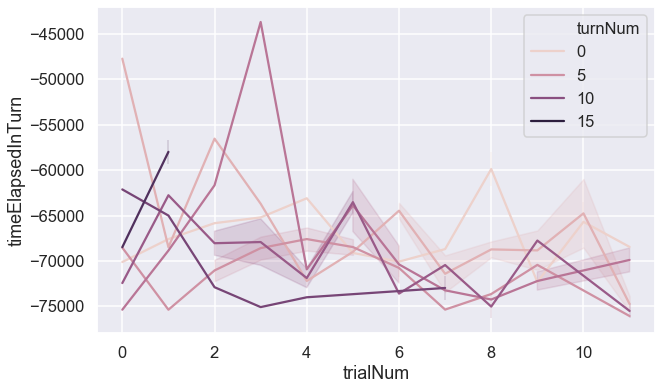

In [298]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].timeElapsedInTurn

# total trial time until final block placement

plt.figure(figsize=(10,6))
sns.lineplot(data=df_block[df_block.gameid =='6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='timeElapsedInTurn', hue='turnNum')


In [279]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6']

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,...,color,block,blockNum,discreteWorld,trialStartTime,turnStartTime,timeElapsedInTurn,timeElapsedInTrial,eventType,practice
196,0,5f4fe3e01034572e6687f9d3,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599071e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,vertical,horizontal,NaN,1,...,"[179, 47, 10, 155]","{'x': 2, 'y': 0, 'width': 1, 'height': 2, 'col...",0,"[[False, False, False, False, False, False, Fa...",1.599071e+12,1.599071e+12,-60051,-17971,block,True
197,1,5f4fe4061034572e6687f9dc,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599071e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,vertical,horizontal,NaN,3,...,"[10, 47, 179, 155]","{'x': 8, 'y': 0, 'width': 2, 'height': 1, 'col...",1,"[[False, False, False, False, False, False, Fa...",1.599071e+12,1.599071e+12,-71099,19168,block,True
198,2,5f4fe4221034572e6687f9e5,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599071e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,L,C,0.0,1,...,"[10, 47, 179, 155]","{'x': 8, 'y': 0, 'width': 2, 'height': 1, 'col...",0,"[[False, False, False, False, False, False, Fa...",1.599071e+12,1.599071e+12,-70126,-56255,block,False
199,3,5f4fe45c1034572e6687f9f0,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599071e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,L,C,0.0,3,...,"[179, 47, 10, 155]","{'x': 0, 'y': 0, 'width': 1, 'height': 2, 'col...",1,"[[True, True, False, False, False, False, Fals...",1.599071e+12,1.599071e+12,-47719,1074,block,False
200,4,5f4fe4831034572e6687f9f5,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599071e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,L,C,0.0,5,...,"[179, 47, 10, 155]","{'x': 9, 'y': 1, 'width': 1, 'height': 2, 'col...",2,"[[True, True, False, False, False, False, Fals...",1.599071e+12,1.599071e+12,-68539,40167,block,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,93,5f4fed981034572e6687fc17,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599074e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,C,L,11.0,5,...,"[10, 47, 179, 155]","{'x': 2, 'y': 5, 'width': 2, 'height': 1, 'col...",3,"[[False, False, False, False, False, False, Fa...",1.599074e+12,1.599074e+12,-76077,12663,block,False
290,94,5f4fedc01034572e6687fc29,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599074e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,C,L,11.0,7,...,"[10, 47, 179, 155]","{'x': 9, 'y': 0, 'width': 2, 'height': 1, 'col...",4,"[[False, False, False, False, False, False, Fa...",1.599074e+12,1.599074e+12,-71210,52678,block,False
291,95,5f4fedc21034572e6687fc2a,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599074e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,C,L,11.0,7,...,"[10, 47, 179, 155]","{'x': 7, 'y': 0, 'width': 2, 'height': 1, 'col...",5,"[[False, False, False, False, False, False, Fa...",1.599074e+12,1.599074e+12,-68576,55312,block,False
292,96,5f4fedd91034572e6687fc34,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599074e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,C,L,11.0,9,...,"[179, 47, 10, 155]","{'x': 7, 'y': 1, 'width': 1, 'height': 2, 'col...",6,"[[False, False, False, False, False, False, Fa...",1.599074e+12,1.599074e+12,-76345,77826,block,False


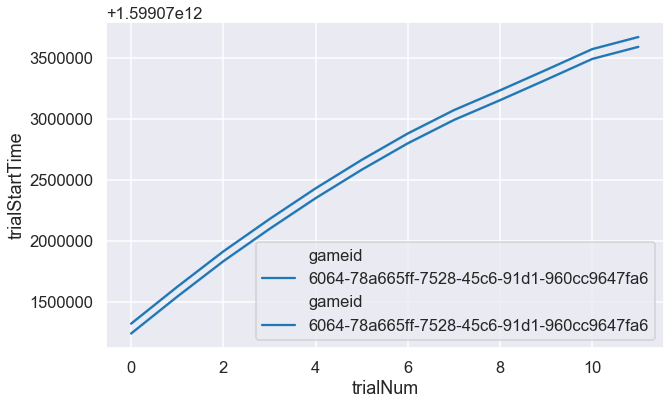

In [291]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].timeElapsedInTurn

# total trial time until final block placement

plt.figure(figsize=(10,6))
sns.lineplot(data=df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='trialStartTime', hue='gameid')
sns.lineplot(data=df_chat[df_chat.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='trialStartTime', hue='gameid')


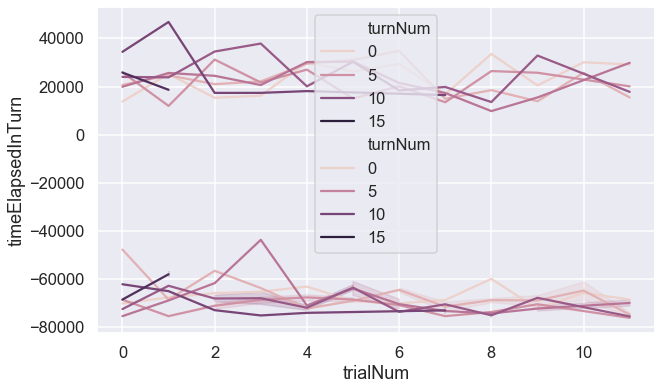

In [297]:
df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].timeElapsedInTurn

# total trial time until final block placement

plt.figure(figsize=(10,6))
sns.lineplot(data=df_block[df_block.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='timeElapsedInTurn', hue='turnNum')
sns.lineplot(data=df_chat[df_chat.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'], x='trialNum', y='timeElapsedInTurn', hue='turnNum')


In [260]:
df_chat[df_chat.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].time - df_chat[df_chat.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6'].turnStartTime 



133    42815.0
134    13527.0
135    14530.0
136    21419.0
137    26658.0
        ...   
196    29916.0
197    16252.0
198    20852.0
199    30637.0
200    18561.0
Length: 68, dtype: float64

In [255]:
df_exit[df_exit.gameid == '6064-78a665ff-7528-45c6-91d1-960cc9647fa6']

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,turnNum,individualPracticeAttempts,...,gameID,nativeEnglish,isHuman,confused,comments,strategy,role,totalLength,pairedPracticeFails,eventType
4,0,5f4fee131034572e6687fc48,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599074e+12,3FIJLY1B6Y46SOB8SHMWCC0MVZNFP6,C,L,0,0,...,A3C5A515KHWU1P,yes,human,yes,NA - fun experiment~~~,Tried to be as descriptive as possible and usu...,listener,2672483,0,exitSurvey
5,1,5f4fee281034572e6687fc4b,pilot4,6064-78a665ff-7528-45c6-91d1-960cc9647fa6,1.599074e+12,3MB8LZR5BJTRHPOO10KMB8J7YL3LKG,C,L,0,0,...,A2ILUP6FN8HKKC,yes,human,yes,NaN,I tried to make things clear as possible~~~,speaker,2711171,0,exitSurvey
